# Quick Detour - What is a reducer function?

In [30]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages, AnyMessage


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages] # we add messages when they go through nodes instead of overriding them.
    

In [31]:
def node1(state):
    
    return {"messages": [2]} # this will be added to the list instead of overriding the list!

# Chaining Pattern for Quiz Generation

Inspired by this [article by Anthropic](https://www.anthropic.com/research/building-effective-agents).

<img src="./2025-02-10-20-01-19.png" width=50%>

In [32]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")

In [33]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.2")

llm_structured = ChatOllama(model="llama3.2", format="json")

In [34]:
from pydantic import BaseModel, Field

class ReviewOutput(BaseModel):
    quiz_score: str = Field(description="'APPROVED' or 'TO-REVIEW'")

llm_reviewer_structured = llm.with_structured_output(ReviewOutput)

input_source = "Persistence in LangGraph means keeping state information of the graph throughout its execution."
initial_quiz = "1. What is life?"

review_prompt = f"""You are a reviewer that scores the quality of quizzes based on input content.
    Consider SOLELY this input below as the source: \n '''{input_source}.'''
    Now, analyse this quiz created based on the input source:\n '''{initial_quiz}'''. 
    Review this quiz and ONLY return:
    - 'APPROVED' if the quiz is good enough, relevant and it covers well all the important contents of the original material. 
    - 'TO-REVIEW' if the quiz is not relevant to the original material showed above, or not comprehensive enough.
    """
    
print(review_prompt)
output = llm_reviewer_structured.invoke(review_prompt)
output.quiz_score

You are a reviewer that scores the quality of quizzes based on input content.
    Consider SOLELY this input below as the source: 
 '''Persistence in LangGraph means keeping state information of the graph throughout its execution..'''
    Now, analyse this quiz created based on the input source:
 '''1. What is life?'''. 
    Review this quiz and ONLY return:
    - 'APPROVED' if the quiz is good enough, relevant and it covers well all the important contents of the original material. 
    - 'TO-REVIEW' if the quiz is not relevant to the original material showed above, or not comprehensive enough.
    


'TO-REVIEW'

In [35]:
from typing_extensions import TypedDict

class QuizState(TypedDict):
    input_source: str
    n_questions: str
    quiz: str
    quiz_quality_score: str
    improved_quiz: str

In [36]:
from langgraph.graph import StateGraph, START, END

def create_quiz(state: QuizState) -> QuizState:
    n_questions = state["n_questions"]
    input_source = state["input_source"]
    quiz = llm.invoke(f"Create a markdown styled quiz with {n_questions} given this content:\n {input_source}")
    return {"quiz": quiz.content}

def review_quiz(state: QuizState) -> QuizState:
    input_source = state["input_source"]
    initial_quiz = state["quiz"]
    review_prompt = f"""You are a reviewer that scores the quality of quizzes based on input content.
    Consider SOLELY this input below as the source: \n '''{input_source}.'''
    Now, analyse this quiz created based on the input source:\n '''{initial_quiz}'''. 
    Review this quiz and ONLY return:
    - 'APPROVED' if the quiz is good enough, relevant, has the right number of questions given the input and it
    covers well all the important contents of the original material. 
    - 'TO-REVIEW' if the quiz is not relevant to the original material showed above, or not comprehensive enough.
    """
    
    quiz_quality_score_output = llm_reviewer_structured.invoke(review_prompt)
    quiz_quality_score = quiz_quality_score_output.quiz_score
    
    return {"quiz_quality_score": quiz_quality_score}

def route_quiz_feedback(state: QuizState) -> QuizState:
    if state["quiz_quality_score"]=="APPROVED":
        return "approved"
    elif state["quiz_quality_score"]=="TO-REVIEW":
        return "improve"
    

def write_improved_quiz(state: QuizState) -> QuizState:
    
    input_source = state["input_source"]
    initial_quiz = state["initial_quiz"]
    
    prompt_improve_quiz = f"""This input was given as the ONLY source: \n\n '''{input_source}'''.
    This is the first version of a quiz based only on this source: '''{initial_quiz}'''.
    Write an improved version of this quiz by:
    
    1. Consider 3 points of improvement
    2. Write the improved version of the quiz integrating the feedback
    3. OUTPUT ONLY THE IMPROVED QUIZ AS A NUMBERED LIST."""
    
    improved_quiz = llm.invoke(prompt_improve_quiz)
    
    return {"improved_quiz": improved_quiz.content}


In [37]:
workflow = StateGraph(QuizState)

workflow.add_node("create_quiz", create_quiz)
workflow.add_node("review_quiz", review_quiz)
workflow.add_node("improve_quiz", write_improved_quiz)

workflow.add_edge(START, "create_quiz")
workflow.add_edge("create_quiz", "review_quiz")
workflow.add_conditional_edges("review_quiz", route_quiz_feedback, {"approved": END, "improve": "improve_quiz"})
workflow.add_edge("improve_quiz", END)

graph = workflow.compile()

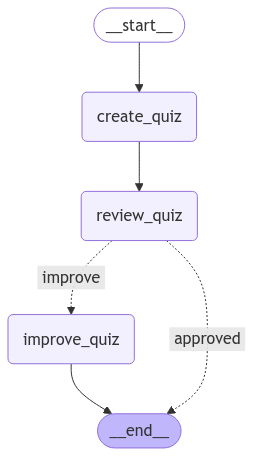

In [38]:
# from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
input_source_raw = """
1. Persistence in LangGraph means keeping state information of the graph throughout its execution
2. In LangGraph there are 2 fundamental questions to ask: 1. Which variables to track across the graph's execution 2. Which intermediate artifacts are useful for debugging?
3. Sub-graphs in langgraph are graphs used as nodes in other graphs (need to share at least 1 key in the state schemas in order to communicate between sub graph and parent graph
4. Command in Langgraph is a node that works to update state and route to other nodes
5. Arguments for why a framework like langgraph can be useful:
    * Implementing foundational agentic patterns does not require a framework like LangGraph.
    * LangGraph aims to minimize overhead of implementing these patterns.
    * LangGraph provides supporting infrastructure underneath any workflow/agent.

    Additionally, here is a breakdown of the specific features mentioned:

    * Persistence:
    + Memory Area
    + Fullscreen Window
    + Scrolling
    + Timer
    + Aa (assuming "Aa" refers to some sort of annotation or feedback mechanism)
    + Recording
    * Human-In-The-Loop:
    + Allows for human intervention and oversight in the workflow/agent
    * Streaming:
    + Enables real-time processing of LLM calls or steps in a workflow/agent
"""

output = graph.invoke({"input_source": input_source_raw,
                       "n_questions": 5})

output

{'input_source': '\n1. Persistence in LangGraph means keeping state information of the graph throughout its execution\n2. In LangGraph there are 2 fundamental questions to ask: 1. Which variables to track across the graph\'s execution 2. Which intermediate artifacts are useful for debugging?\n3. Sub-graphs in langgraph are graphs used as nodes in other graphs (need to share at least 1 key in the state schemas in order to communicate between sub graph and parent graph\n4. Command in Langgraph is a node that works to update state and route to other nodes\n5. Arguments for why a framework like langgraph can be useful:\n    * Implementing foundational agentic patterns does not require a framework like LangGraph.\n    * LangGraph aims to minimize overhead of implementing these patterns.\n    * LangGraph provides supporting infrastructure underneath any workflow/agent.\n\n    Additionally, here is a breakdown of the specific features mentioned:\n\n    * Persistence:\n    + Memory Area\n    +

In [40]:
from IPython.display import Markdown

Markdown(output["quiz"])

**LangGraph Fundamentals Quiz**
=====================================

### Questions

#### 1. What does persistence in LangGraph refer to?

* A) The process of updating the graph's state
* B) Keeping state information of the graph throughout its execution
* C) Creating new sub-graphs
* D) Optimizing workflow performance

#### Answer: B) Keeping state information of the graph throughout its execution

#### 2. What are the two fundamental questions to ask when designing LangGraph?

* A) Which nodes to include in the graph and which to exclude?
* B) Which variables to track across the graph's execution and which intermediate artifacts are useful for debugging?
* C) How to optimize the workflow for maximum efficiency
* D) What is the best way to handle human intervention in the workflow

#### Answer: B) Which variables to track across the graph's execution and which intermediate artifacts are useful for debugging?

#### 3. What is a sub-graph in LangGraph?

* A) A node that processes input data
* B) A group of connected nodes that work together
* C) A separate instance of a workflow or agent
* D) A way to visualize the graph's structure

#### Answer: C) A separate instance of a workflow or agent

#### 4. What is a command in LangGraph?

* A) A node that processes input data
* B) A type of intermediate artifact used for debugging
* C) A node that works to update state and route to other nodes
* D) A way to visualize the graph's structure

#### Answer: C) A node that works to update state and route to other nodes

#### 5. Why can a framework like LangGraph be useful?

* A) Because it allows for human intervention in the workflow
* B) Because it provides supporting infrastructure underneath any workflow/agent
* C) Both A and B
* D) Neither A nor B

#### Answer: C) Both A and B

# Parallel Pattern

In [2]:
# Parallel Pattern with LangGraph
from typing_extensions import TypedDict
from IPython.display import display, Image
from langgraph.graph import StateGraph, END, START
from langchain_ollama import ChatOllama

In [ ]:
class ExplainationState(TypedDict):
    question: str
    analogy: str
    examples: str
    plain_english: str
    technical_definition: str
    full_explanation: str



llm = ChatOllama(model="llama3.2")
def generate_analogy(state: ExplainationState)->ExplainationState:
    
    question = state["question"]
    analogy_prompt = f"""
    Given this question by the user:
    {question}
    Explain it by providing an analogy to help.
    """
    analogy_output = llm.invoke(analogy_prompt)
    return {"analogy":  analogy_output.content}

def generate_example(state: ExplainationState)->ExplainationState:
    question = state["question"]
    example_prompt = f"""Given this question by the user: 
    {question}
    Provide 3 examples to help clarify it or demonstrate it in context.
    Your OUTPUT SHOULD ONLY BE the examples as a bullet point list."""
    
    examples_output = llm.invoke(example_prompt)
    
    return {"examples": examples_output.content}

def explain_plain_english(state: ExplainationState)->ExplainationState:
    question = state["question"]
    
    plain_english_prompt = f"""
    Given this question by the user:
    {question}
    Explain it in simple plain english terms in less than 2 paragraphs.
    Output plain english explanation:
    """
    output_plain_english = llm.invoke(plain_english_prompt)

    return {"plain_english":output_plain_english.content}

def explain_technical_definition(state: ExplainationState)->ExplainationState:
    question = state["question"]
    
    technical_definition_prompt = f"""
    Given this question by the user:
    {question}
    Explain it in technical terms not using more than 2 paragraphs. Make sure to be rigid and
    give the official technical definition required that answers the question.
    Output technical definition:
    """
    technical_definition_output = llm.invoke(technical_definition_prompt)
    return {"technical_definition": technical_definition_output.content}

def generate_final_explanation(state: ExplainationState)->ExplainationState:

    question = state["question"]
    analogy = state["analogy"]
    examples = state["examples"]
    plain_english = state["plain_english"]
    technical_definition = state["technical_definition"]
    
    full_explanation = f"""
    # Final answer
    
    ## Analogy
    
    {analogy}
    
    ## Examples
    
    {examples}
    
    ## Plain English
    
    {plain_english}
    
    ## Technical Definition
    
    {technical_definition}
    
    """
    
    return {"full_explanation": full_explanation}

In [ ]:
workflow = StateGraph(ExplainationState)

workflow.add_node("generate_analogy",generate_analogy)
workflow.add_node("generate_example",generate_example)
workflow.add_node("explain_plain_english",explain_plain_english)
workflow.add_node("explain_technical_definition",explain_technical_definition)
workflow.add_node("generate_final_explanation",generate_final_explanation)

workflow.add_edge(START, "generate_analogy")
workflow.add_edge(START, "generate_example")
workflow.add_edge(START, "explain_plain_english")
workflow.add_edge(START,"explain_technical_definition")

workflow.add_edge("generate_analogy","generate_final_explanation")
workflow.add_edge("generate_example","generate_final_explanation")
workflow.add_edge("explain_plain_english","generate_final_explanation")
workflow.add_edge("explain_technical_definition","generate_final_explanation")
workflow.add_edge("generate_final_explanation",END)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))
graph.invoke({"question": "Explain the concept of self-attention in transformers (context is large language models)."})

# Routing

Let's look at a simple example of routing between LLMs. We'll create a workflow that:

1. Takes a user question
2. Routes it to one of three specialized agents:
   - Code explanation agent
   - Math problem solver
   - General knowledge agent
3. Gets the specialized response

For this example we will be using an LLM with [structured output](https://platform.openai.com/docs/guides/structured-outputs) capabilities
in order to obtain an output from the LLM in a controllable format (json) which we can then extract a key that will
be used to route a question to one of 3 different LLMs (containing different prompts).

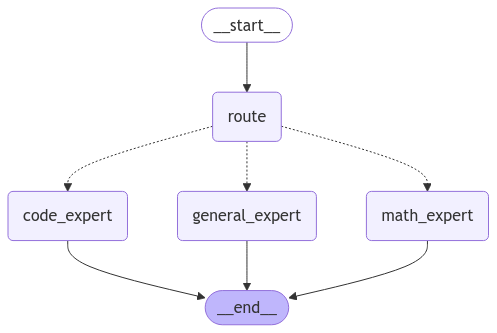

In [28]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, END
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

# Define our state
class RoutingState(TypedDict):
    question: str  # Input question
    category: str | None # Routing classification
    answer: str | None  # Final answer

class QuestionType(BaseModel):
    category: str = Field(description="The category classification of the question: CODE or MATH or GENERAL")

llm = ChatOpenAI(model="gpt-4o")
llm_with_structured_output = llm.with_structured_output(QuestionType)

# Router that classifies the question
def route_question(state: RoutingState):
    question = state["question"]
    response = llm_with_structured_output.invoke(
        f"""Classify this question into exactly ONE category:
        - CODE if about programming/coding
        - MATH if about mathematical calculations
        - GENERAL for general knowledge
        Question: {question}
        Category:"""
    )
    print(response)
    return {"category": response.category}

# Specialized agents
def code_expert(state: RoutingState):
    print("Using code expert!")
    return {"answer": llm.invoke(f"As a coding expert, answer: {state['question']}")}

def math_expert(state: RoutingState):
    print("Using math expert")
    return {"answer": llm.invoke(f"As a math expert, solve: {state['question']}")}

def general_expert(state: RoutingState):
    print("Using general expert")
    return {"answer": llm.invoke(f"Answer this general question: {state['question']}")}

# Define routing logic
def router(state: RoutingState):
    if state["category"] == "CODE":
        return "code_expert"
    elif state["category"] == "MATH":
        return "math_expert"
    else:
        return "general_expert"

# Create and configure workflow
workflow = StateGraph(RoutingState)

# Add nodes
workflow.add_node("route", route_question)
workflow.add_node("code_expert", code_expert)
workflow.add_node("math_expert", math_expert) 
workflow.add_node("general_expert", general_expert)

# Add edges
workflow.add_edge(START, "route")
workflow.add_conditional_edges(
    "route",
    router,
    {
        "code_expert": "code_expert",
        "math_expert": "math_expert",
        "general_expert": "general_expert"
    }
)
workflow.add_edge("code_expert", END)
workflow.add_edge("math_expert", END)
workflow.add_edge("general_expert", END)

# Compile and run
graph = workflow.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [29]:
graph.invoke({
     "question": "What is the time complexity of quicksort?",   # Routes to code expert
     "category": None,
     "answer": None
 })

category='CODE'
Using code expert!


{'question': 'What is the time complexity of quicksort?',
 'category': 'CODE',
 'answer': AIMessage(content='The time complexity of the quicksort algorithm can vary depending on the circumstances:\n\n1. **Average Case:** The average time complexity of quicksort is \\(O(n \\log n)\\), where \\(n\\) is the number of elements in the array. This is because the partitioning process divides the array into two parts, and the recursion depth is approximately \\(\\log n\\), with each level of recursion requiring \\(O(n)\\) work to partition the array.\n\n2. **Best Case:** The best-case time complexity is also \\(O(n \\log n)\\). This occurs when the pivot selection results in equally balanced partitions at each step, leading to a perfectly balanced recursive tree.\n\n3. **Worst Case:** The worst-case time complexity is \\(O(n^2)\\). This occurs when the pivot selection results in highly unbalanced partitions, such as when the smallest or largest element is consistently chosen as the pivot. An e